# 一、初始化
## 載入 PYNQ 庫

In [305]:
from pynq import Overlay, GPIO, Register, Xlnk
import numpy as np
from PIL import Image
import cffi
import time
import tempfile
import itertools

## 配置 FPGA

In [306]:
overlay = Overlay('VGG4CIFAR.bit')

## 定義 ResetPin & CtrlReg

In [307]:
RESET_VALUE = 0
NRESET_VALUE = 1

MYBNN_AP_CTRL_OFF = 0x00
MYBNN_AP_CTRL_START_IDX = 0
MYBNN_AP_CTRL_DONE_IDX  = 1
MYBNN_AP_CTRL_IDLE_IDX  = 2
MYBNN_AP_CTRL_READY_IDX = 3
MYBNN_COEFF_OFFS  = [0x1c, 0x28, 0x34, 0x40, 0x4c, 0x58, 0x64, 0x70, 0x7c]
MYBNN_LENGTH_OFF  = 0x10

overlay.__resetPin = GPIO(GPIO.get_gpio_pin(0), "out")
overlay.__ap_ctrl = Register(overlay.BlackBoxJam.mmio.base_addr, 32)
overlay.xlnk = Xlnk()

## 開啟測試圖片

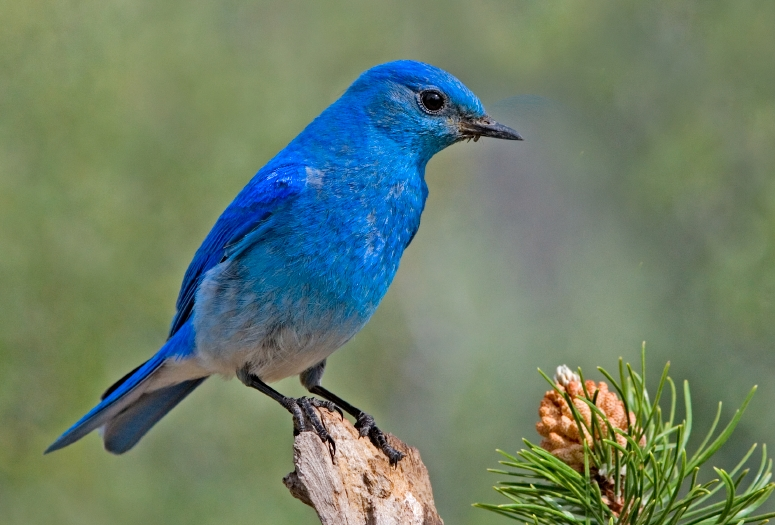

In [308]:
path = "./bird.jpg"
im = Image.open(path)
im

# 二、使用 ARM-FPGA 異構運算
## 轉換圖片格式

In [309]:
signal = []
numpic = 64
coeffs = [1, 0, 0, 0, 0, 0, 0, 0, 0]
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]

In [310]:
with tempfile.NamedTemporaryFile() as tmp:
    im.thumbnail((32, 32), Image.ANTIALIAS)
    background = Image.new('RGBA', (32, 32), (255, 255, 255, 0))
    background.paste(
        im, (int((32 - im.size[0]) / 2), int((32 - im.size[1]) / 2))
    )
    im = (np.array(background))
    r = im[:,:,0].flatten()
    g = im[:,:,1].flatten()
    b = im[:,:,2].flatten()
    label = np.identity(1, dtype=np.uint8)
    tmp.write(label.tobytes())
    tmp.write(r.tobytes())
    tmp.write(g.tobytes())
    tmp.write(b.tobytes())
    tmp.flush()
    
    imgpath = tmp.name
        
    _ffi = cffi.FFI()
    _ffi.cdef("""
    void load_parameters(const char* path);
    unsigned int inference(const char* path, unsigned long long int results[384], int number_class, float *usecPerImage);
    unsigned int* inference_multiple(const char* path, int number_class, int *image_number, float *usecPerImage, unsigned int enable_detail);
    void free_results(unsigned int * result);
    void deinit();
    """
    )

    _libraries = {}
    dllname = "python_sw-cnv-pynq.so"
    if dllname not in _libraries:
        _libraries[dllname] = _ffi.dlopen("./python_sw-cnv-pynq.so")
    interface = _libraries[dllname]

    usecperimage = _ffi.new("float *") 
    result_ptr = _ffi.new("unsigned long long int [384]")
    interface.inference(imgpath.encode(), result_ptr, 10, usecperimage)
    arr_out = np.frombuffer(_ffi.buffer(result_ptr, 384*8), dtype=np.uint64)
    
    for j in range(numpic):
        for i in arr_out:
            signal.append(i)
    len(signal)

## 放開 Reset 

In [311]:
overlay.__resetPin.write(NRESET_VALUE)

## 載入參數

In [312]:
for (offset, coeff) in zip(MYBNN_COEFF_OFFS, coeffs):
    overlay.BlackBoxJam.write(offset, coeff)
    
overlay.BlackBoxJam.write(MYBNN_LENGTH_OFF, numpic)

## 申請 DMA 記憶體空間

In [313]:
cmabuf_src = overlay.xlnk.cma_array([len(signal)], np.uint64)
cmabuf_dest = overlay.xlnk.cma_array(numpic*16+1, np.uint64)

## 準備輸入資料

In [314]:
for i in range(len(signal)):
    cmabuf_src[i] = signal[i]

## 初始化 DMA

In [315]:
overlay.hlsDmaEngine.sendchannel.transfer(cmabuf_src)
overlay.hlsDmaEngine.recvchannel.transfer(cmabuf_dest)

## 啟動計算核心並等待 DMA 中斷

In [316]:
overlay.__ap_ctrl[MYBNN_AP_CTRL_START_IDX] = 1

t0 = time.clock()

overlay.hlsDmaEngine.sendchannel.wait()
overlay.hlsDmaEngine.recvchannel.wait()

t1 = time.clock()

overlay.__ap_ctrl[MYBNN_AP_CTRL_START_IDX] = 0

## 鎖住 Reset 

In [317]:
overlay.__resetPin.write(RESET_VALUE)

## 取回輸出資料

In [318]:
output = cmabuf_dest.tolist()

## 釋放空間

In [319]:
cmabuf_dest.freebuffer()
cmabuf_src.freebuffer()

# 三、驗證結果

In [320]:
import math

ans = []
for k in range(0,3):
    bb = bin(output[k])[2:].zfill(64)
    for j in range(0,4):
        temp = ""
        for i in range(0,16):
            temp += bb[len(bb)-1-j*16-i]
        ans.append(int(temp[::-1],2))
ans.pop()
ans.pop()

size = ((64*len(signal))/(8*1024*1024))
print("ANS:",classes[ans.index(max(ans))])
print("Latency:",(t1-t0)*math.pow(10, 3),"ms")
print("Second per image:",(t1-t0)*math.pow(10, 6)/numpic, "us")
print("FPS:",numpic/(t1-t0))
print("Throughput:",size*(1/(t1-t0))*2, "MB/s")
print("Data size:",size,"MB")

ANS: Bird
Latency: 71.44200000000467 ms
Second per image: 1116.281250000073 us
FPS: 895.831583662213
Throughput: 5.249013185520779 MB/s
Data size: 0.1875 MB
